# Binary classification and logistic regression

- **Task**: given input features `x` (e.g., tumor measurements), predict whether the outcome is class `0` or `1`.
- **Examples**:
  - Medical: `1` = malignant tumor, `0` = benign
  - Safety: `1` = failure within 30 days, `0` = no failure
  - Email: `1` = spam, `0` = not spam
- **Outputs**:
  - A probability `p(x) = P(y=1 | x)` between 0 and 1
  - A class prediction by comparing `p(x)` to a threshold (often 0.5)


### How does logistic regression produce probabilities?

- It first computes a linear combination of the inputs: $z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p = \beta^T x$.
- Then it maps `z` to a valid probability using the logistic (sigmoid) function: $\sigma(z) = \frac{1}{1 + e^{-z}}$.
- This link function ensures outputs are in `[0, 1]` and creates an S-shaped probability curve.

### How is the model trained?

- Assumes labels are Bernoulli distributed with probability $p(x)$.
- Chooses coefficients $\beta$ to maximize the likelihood of the observed data (equivalently, minimize cross-entropy loss).
- The loss function is convex for logistic regression, so a global optimum is found.

### How are coefficients interpreted?

- Coefficients live on the logit space: $\log \frac{p(x)}{1-p(x)} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p = \beta^T x$.
- A one-unit increase in feature $x_j$ changes the logit by $\beta_j$.
- $\exp(\beta_j)$ is the increase (in multiplicative terms) of odds ratio per due to a unit increase of $x_j$.

In [1]:
# Core libraries for plotting, arrays, dataframes, and statistical modeling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Configure display options and Seaborn plotting style
pd.set_option("display.max_columns", 500)
plt.rcParams["figure.figsize"] = (10, 6)
sns.set(font_scale=1.3)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

## Binary classification example

Wisconsin breast cancer diagnostic dataset. The data dictionary can be found [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

In [2]:
# Load Wisconsin Breast Cancer (Diagnostic) dataset
breast_cancer_data = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/breast_cancer.csv")
# Quick peek at the columns and first rows
breast_cancer_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_mean,symmetry_mean,fractal_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_se,symmetry_se,fractal_se,radius_extreme,texture_extreme,perimeter_extreme,area_extreme,smoothness_extreme,compactness_extreme,concavity_extreme,concave_extreme,symmetry_extreme,fractal_extreme
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Titanic survivor dataset. The data dictionary can be found [here](https://www.kaggle.com/c/titanic/data).

In [3]:
# Load Titanic passenger dataset
titanic_data = pd.read_csv("https://raw.githubusercontent.com/changyaochen/MECE4520/master/data/titanic.csv")
# Preview
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## EDA

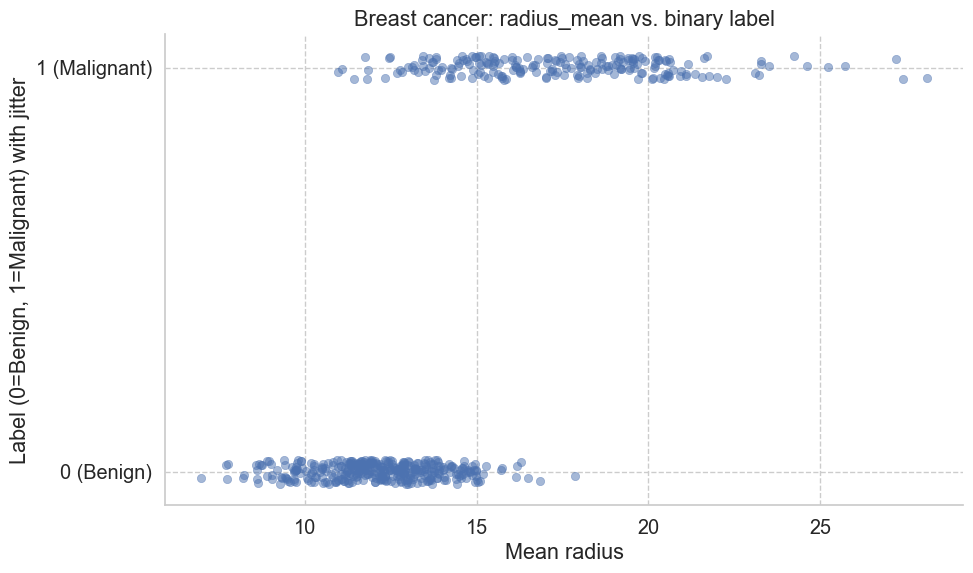

In [4]:
# Create binary label: 0 = Benign (B), 1 = Malignant (M)
breast_cancer_data["label"] = breast_cancer_data["diagnosis"].apply(lambda x: 0 if x == "B" else 1)

# Jitter the binary target for visibility in scatter
rng = np.random.default_rng(0)
y_jitter = breast_cancer_data["label"] + rng.uniform(-0.03, 0.03, size=len(breast_cancer_data))

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    x="radius_mean",
    y=y_jitter,
    data=breast_cancer_data,
    alpha=0.5,
    edgecolor=None,
    ax=ax,
)
ax.set(
    xlabel="Mean radius",
    ylabel="Label (0=Benign, 1=Malignant) with jitter",
    title="Breast cancer: radius_mean vs. binary label",
)
ax.set_yticks([0, 1])
ax.set_yticklabels(["0 (Benign)", "1 (Malignant)"])
sns.despine()
plt.tight_layout()

## Logistic regression

In [5]:
# Fit logistic regression (GLM with binomial family and logit link)
model = smf.glm(
    formula="label ~ radius_mean",
    data=breast_cancer_data,
    family=sm.families.Binomial(),
)
result = model.fit()

# Model summary with coefficient estimates, standard errors, and significance
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  label   No. Observations:                  569
Model:                            GLM   Df Residuals:                      567
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -165.01
Date:                Wed, 01 Oct 2025   Deviance:                       330.01
Time:                        21:08:57   Pearson chi2:                     489.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5232
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -15.2459      1.325    -11.509      

### Interpreting coefficients and choosing thresholds

- The intercept and slope are on the logit scale. A one-unit increase in `radius_mean` changes the logit of malignancy by $\beta_{\text{radius mean}}$.
- $\exp(\beta_{\text{radius mean}})$ is the multiplicative change in odds per unit increase.
- Predicted probability is $p = 1 / (1 + e^{-(β_0 + β_{\text{radius mean}} x)})$.
- A default decision threshold of 0.5 classifies as malignant if `p ≥ 0.5`. Depending on costs, one may choose a lower or higher threshold to trade off sensitivity and specificity.


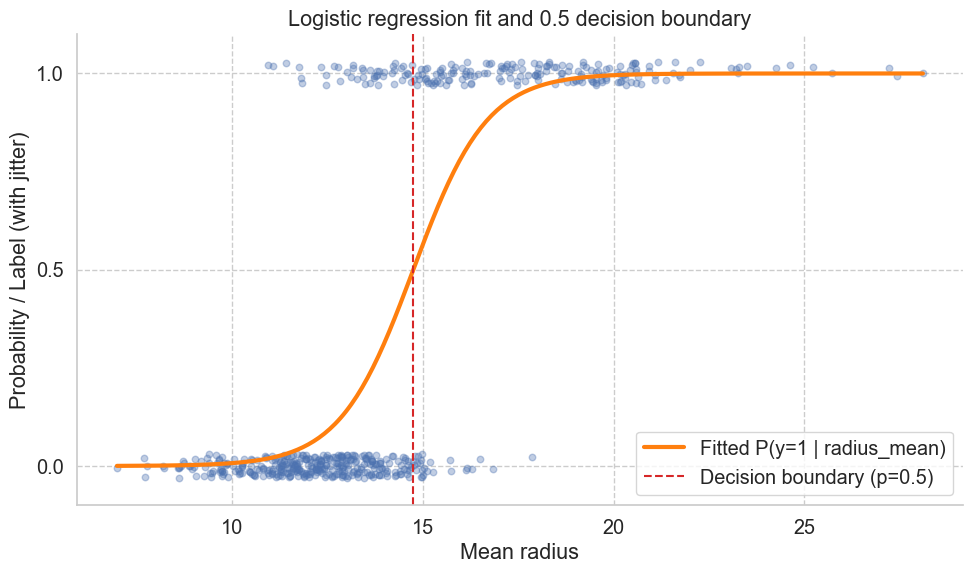

In [6]:
# Plot fitted probability curve and 0.5 decision boundary
x_grid = np.linspace(breast_cancer_data["radius_mean"].min(), breast_cancer_data["radius_mean"].max(), 300)
pred_df = pd.DataFrame({"radius_mean": x_grid})
p_grid = result.predict(pred_df)

# Decision boundary where p=0.5 => β0 + β1 x = 0
beta0 = result.params["Intercept"]
beta1 = result.params["radius_mean"]
x_boundary = -beta0 / beta1

# Scatter actual labels with jitter for visibility
rng = np.random.default_rng(1)
y_jitter = breast_cancer_data["label"] + rng.uniform(-0.03, 0.03, size=len(breast_cancer_data))

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(breast_cancer_data["radius_mean"], y_jitter, alpha=0.35, s=22)
ax.plot(x_grid, p_grid, color="tab:orange", linewidth=3, label="Fitted P(y=1 | radius_mean)")
ax.axvline(x_boundary, color="tab:red", linestyle="--", label="Decision boundary (p=0.5)")

ax.set(
    xlabel="Mean radius",
    ylabel="Probability / Label (with jitter)",
    title="Logistic regression fit and 0.5 decision boundary",
)
ax.set_yticks([0, 0.5, 1])
ax.set_ylim(-0.1, 1.1)
ax.legend()
sns.despine()
plt.tight_layout()


In [7]:
# Plotly interactive 3D probability surface with decision boundary and data points
import plotly.graph_objects as go

model_2 = smf.glm(
    formula="label ~ radius_mean + smoothness_mean",
    data=breast_cancer_data,
    family=sm.families.Binomial(),
)
result_2 = model_2.fit()

# Build grid over feature space
x_min, x_max = breast_cancer_data["radius_mean"].min(), breast_cancer_data["radius_mean"].max()
y_min, y_max = breast_cancer_data["smoothness_mean"].min(), breast_cancer_data["smoothness_mean"].max()
x_pad = 0.02 * (x_max - x_min)
y_pad = 0.02 * (y_max - y_min)
x_vals = np.linspace(x_min - x_pad, x_max + x_pad, 120)
y_vals = np.linspace(y_min - y_pad, y_max + y_pad, 120)
X, Y = np.meshgrid(x_vals, y_vals)

pred_grid = pd.DataFrame({"radius_mean": X.ravel(), "smoothness_mean": Y.ravel()})
P = result_2.predict(pred_grid).values.reshape(X.shape)

# Decision boundary (logit=0)
beta0 = result_2.params["Intercept"]
beta1 = result_2.params["radius_mean"]
beta2 = result_2.params["smoothness_mean"]
x_line = np.linspace(x_min, x_max, 500)
if abs(beta2) > 1e-12:
    y_line = -(beta0 + beta1 * x_line) / beta2
    mask = (y_line >= y_min - y_pad) & (y_line <= y_max + y_pad)
    x_line = x_line[mask]
    y_line = y_line[mask]
else:
    x_line = np.array([])
    y_line = np.array([])

# Jittered original data points
rng = np.random.default_rng(2)
y_jitter = breast_cancer_data["label"] + rng.uniform(-0.03, 0.03, size=len(breast_cancer_data))

fig = go.Figure()

# Surface
fig.add_trace(
    go.Surface(
        x=X,
        y=Y,
        z=P,
        colorscale="Viridis",
        opacity=0.7,
        showscale=True,
        colorbar=dict(title="Predicted P(y=1)", thickness=12, len=0.6)
    )
)

# Decision boundary line at z=0.5
if x_line.size > 0:
    fig.add_trace(
        go.Scatter3d(
            x=x_line,
            y=y_line,
            z=np.full_like(x_line, 0.5),
            mode="lines",
            line=dict(color="black", width=10, dash="dash"),
            name="p = 0.5 boundary",
        )
    )

# Original points colored by label
labels_np = breast_cancer_data["label"].to_numpy(dtype=int)
colors = np.where(labels_np == 1, "crimson", "royalblue")
fig.add_trace(
    go.Scatter3d(
        x=breast_cancer_data["radius_mean"],
        y=breast_cancer_data["smoothness_mean"],
        z=y_jitter,
        mode="markers",
        marker=dict(size=3.5, color=colors, opacity=0.6),
        name="Data (jittered label)",
        hovertemplate=(
            "radius_mean=%{x:.3f}<br>smoothness_mean=%{y:.4f}<br>label~%{z:.2f}<extra></extra>"
        ),
    )
)

fig.update_layout(
    title="Interactive logistic regression surface and decision boundary",
    scene=dict(
        xaxis_title="radius_mean",
        yaxis_title="smoothness_mean",
        zaxis_title="Probability / Label (jittered)",
        zaxis=dict(range=[-0.1, 1.1])
    ),
    width=900,
    height=600,
    margin=dict(l=0, r=0, t=60, b=0),
)

fig.show()
